## Семинар 8: "Снижение размерности"

ФИО: __Господинов Георгий__

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
%matplotlib inline

Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [2]:
X = fetch_olivetti_faces()['data']

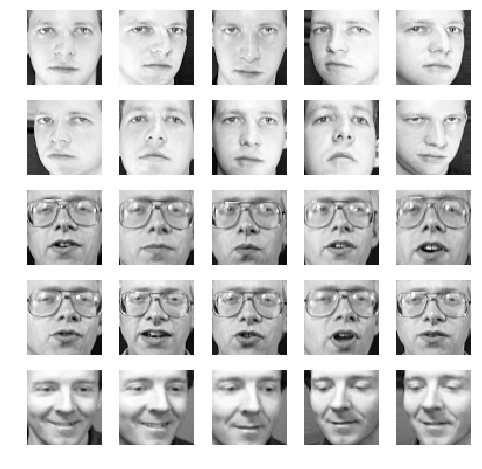

In [3]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [4]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

Подсказка: используйте метод <b>.components_</b>

In [5]:
X.shape

(400, 4096)

In [6]:
model = PCA(n_components=25)
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [7]:
principle_components = model.components_

In [8]:
principle_components.shape

(25, 4096)

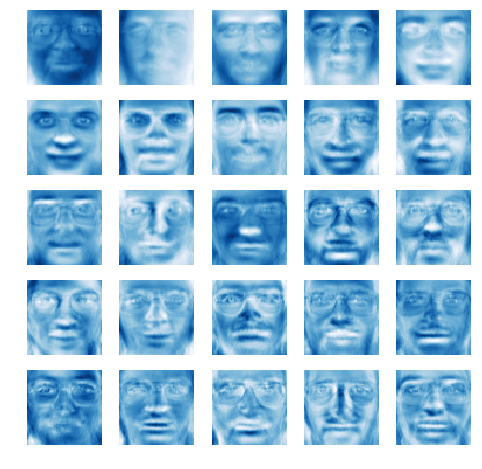

In [122]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(principle_components[i].reshape(64, 64), cmap='Blues_r')
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>

Подсказка: используйте метод <b>.explained\_variance\_ratio\_</b>

In [10]:
model = PCA()
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0,0.5,'Reconstruction quality (MSE)')

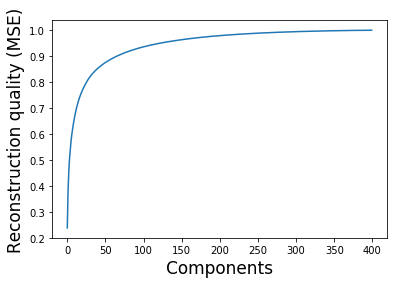

In [11]:
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('Components', fontsize=17)
plt.ylabel('Reconstruction quality (MSE)', fontsize=17)

In [26]:
def FitReconstructPCA(n_components):
    model = PCA(n_components=n_components)
    model.fit(X)
    embedding = model.transform(X)
    reconstruction = model.inverse_transform(embedding)
    
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow((X)[1].reshape(64, 64), cmap='Blues_r')
    plt.axis('off')
    plt.title('Original', fontsize=20)
    plt.subplot(1, 3, 2)
    plt.imshow((reconstruction)[1].reshape(64, 64), cmap='Blues_r')
    plt.axis('off')
    plt.title('Reconstruction', fontsize=20)
    plt.subplot(1, 3, 3)
    plt.imshow((reconstruction - X)[1].reshape(64, 64), cmap='Blues_r')
    plt.axis('off')
    plt.title('Error', fontsize=20)

    print('max error: ', np.max((reconstruction - X)[1]))
    plt.show()

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

n_components:  25
max error:  0.27648368


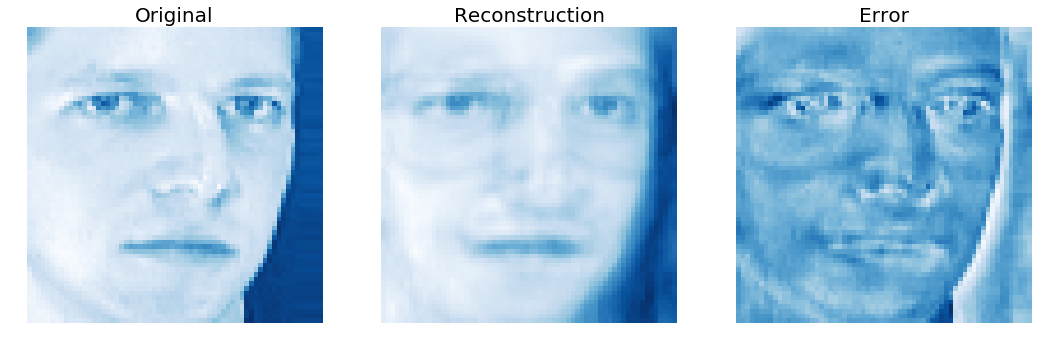

n_components:  100
max error:  0.18474512


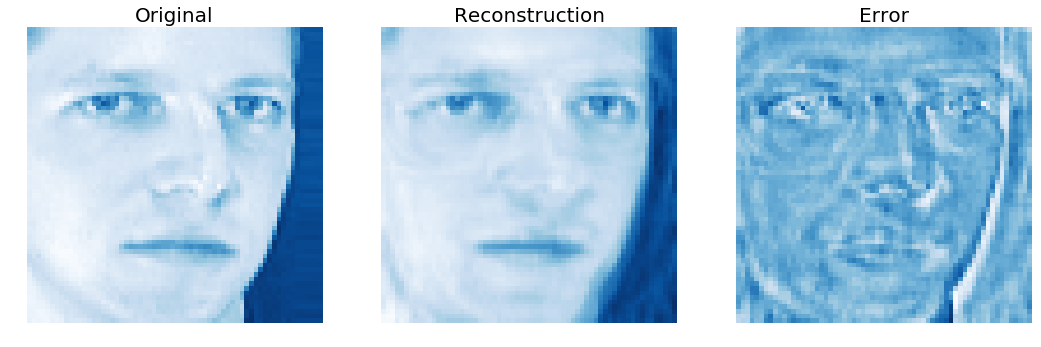

n_components:  150
max error:  0.13029191


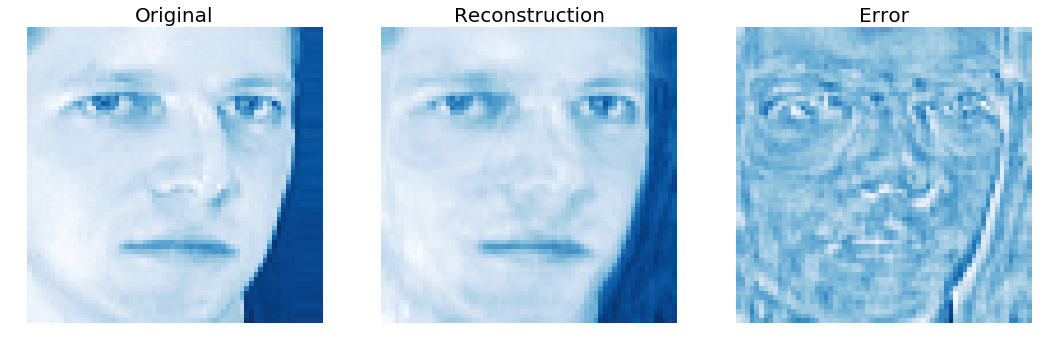

n_components:  200
max error:  0.09689963


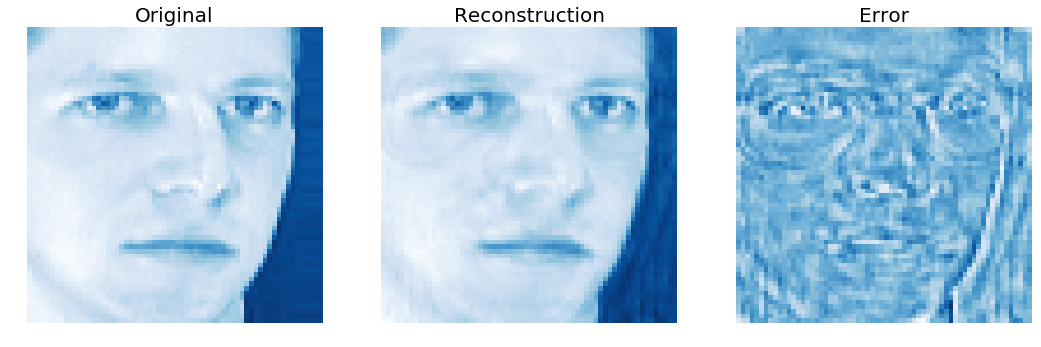

n_components:  300
max error:  0.033710003


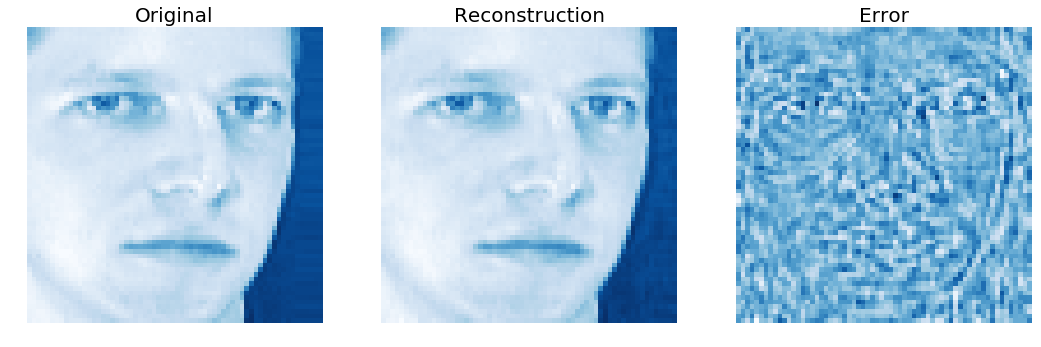

In [30]:
for n_components in [25, 100, 150, 200, 300]:
    print('n_components: ', n_components)
    FitReconstructPCA(n_components=n_components)

При использовании 25, 100, 150, 200 компонент визуально качество отличается не сильно, но структура очков на реконструированном изображении видна отчетливо. С моей точки зрения, 300 компонент - это оптимум.

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [42]:
model = PCA(n_components=2)
model.fit(X)
embedding = model.transform(X)
reconstruction = model.inverse_transform(embedding)

In [72]:
def plot_dataset(X, emb, margin=0, frame=1000., imsize=64):
    assert(emb.shape[1] == 2)
    emb = np.array((emb - emb.min(0)) * (frame / (emb.max(0) - emb.min(0))) + margin, dtype = np.int)
    image = np.zeros((int(emb[:, 0].max() + margin + imsize), int(emb[:, 1].max() + margin + imsize))) + 1
    for k in range(X.shape[0]):
        image[emb[k, 0]:emb[k, 0]+64, emb[k, 1]:emb[k, 1]+64] = X[k].reshape(64, 64)
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Blues_r")
    plt.axis("off")
    plt.show()

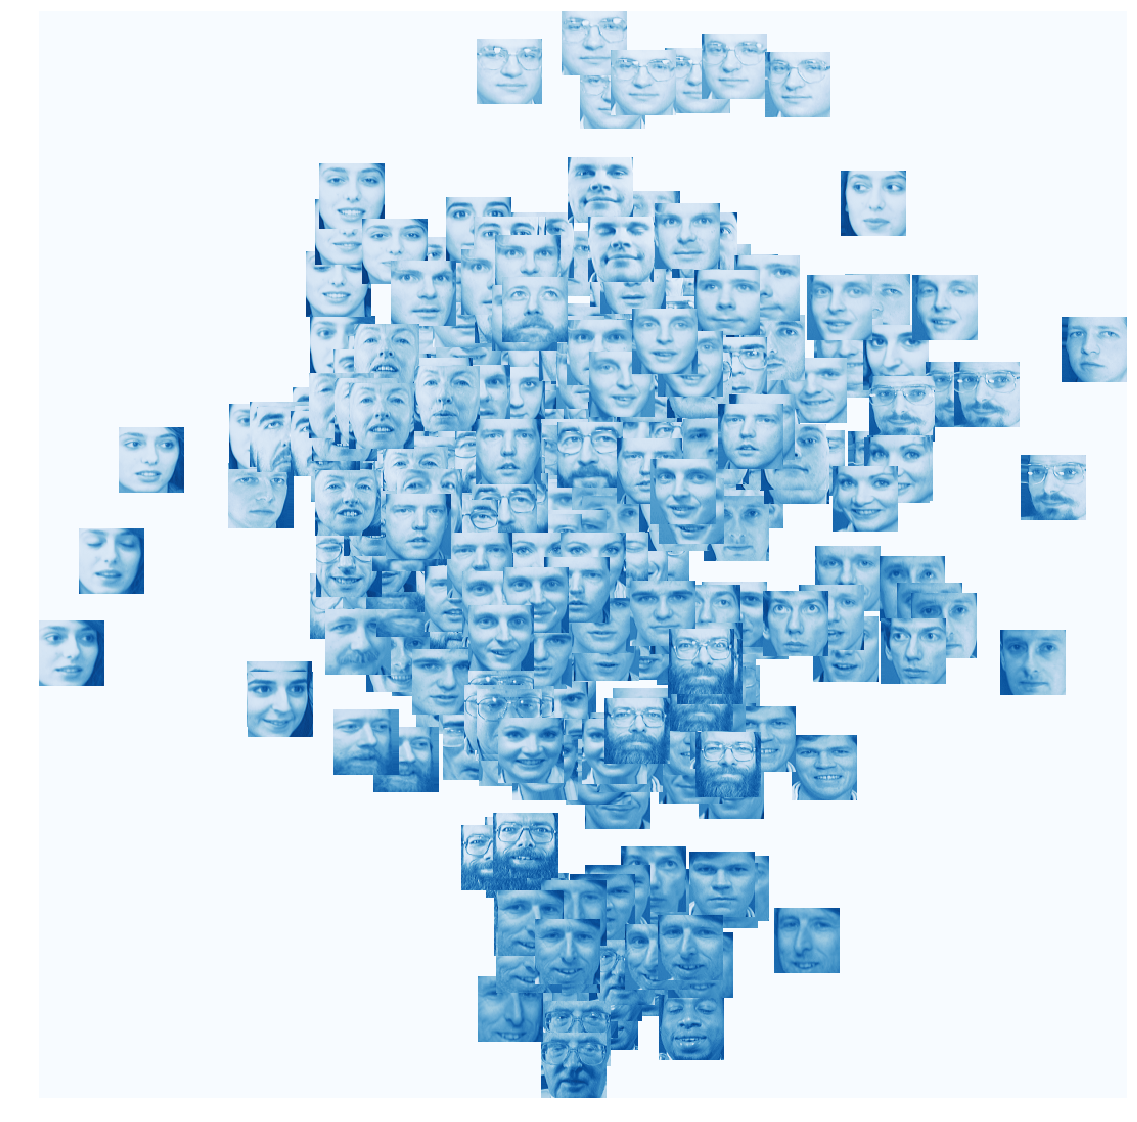

In [73]:
plot_dataset(X, embedding)

Первая компонента — освещение, вторая — в какую сторону смотрит человек

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

Для улучшения сходимости размер батча был уменьшен с 400 до 100, перед каждым линейным слоем добавлена нормализация.

In [74]:
from torch.utils.data import DataLoader, Dataset

In [75]:
dataloader = DataLoader(X, batch_size=100, shuffle=True)

In [76]:
def fully_connected(arc, last_nonlinearity=True):
    layers = []
    for i in range(len(arc)-1):
        layers.append(nn.BatchNorm1d(num_features=arc[i]))
        layers.append(nn.Linear(arc[i], arc[i+1]))
        if i != len(arc)-2 or last_nonlinearity:
            layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)

In [124]:
class AE(nn.Module):
    def __init__(self, arc_encoder, arc_decoder):
        super(AE, self).__init__()
        # create encoder:
        self.encoder = fully_connected(arc_encoder, last_nonlinearity=False)
        self.decoder = fully_connected(arc_decoder, last_nonlinearity=False)
        
    def encode(self, X):
        return self.encoder(X)
    
    def decode(self, X):
        return self.decoder(X)
        
    def forward(self, X):
        return self.decoder(self.encoder(X))

In [125]:
import sys

def fit(model, show_loss=False, show_convergence=True,):
    loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    Losses = []
    for epoch in range(200):
        losses = []
        for x in dataloader:
            x_batch = Variable(x)
            y_batch = Variable(x, requires_grad=False)
            model.zero_grad()
            x_reconstruction = model(x_batch)
            loss_batch = loss(x_reconstruction, y_batch)
            loss_batch.backward()
            optimizer.step()
            losses.append(loss_batch.data[0])
        Losses.append(np.mean(losses))
        if show_convergence:
            sys.stdout.write('\r {}'.format(np.mean(losses)))
    
    if show_loss:
        plt.plot(Losses)
        plt.ylabel('MSE', fontsize=16)
        plt.xlabel('epochs', fontsize=16)
        plt.yscale('log')
        plt.grid()
        plt.show()
    
    return np.min(Losses)

def fit_reconstruct(model, show_loss=False, show_convergence=True, distinct=False):
    min_loss = fit(model, show_loss=show_loss, show_convergence=show_convergence)
    
    reconstructions = model(Variable(torch.Tensor(X))).data.numpy()
    indexes = np.random.choice(range(400), 3, replace=False)
    if distinct:
        indexes = [314]
    for index in indexes:
        plt.subplot(1, 2, 1)
        plt.imshow(X[index].reshape(64, 64), cmap='Blues_r')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructions[index].reshape(64, 64), cmap='Blues_r')
        plt.axis('off')
        plt.show()
    
    return min_loss

/Users/g.gospodinov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 0.0069463080726563934

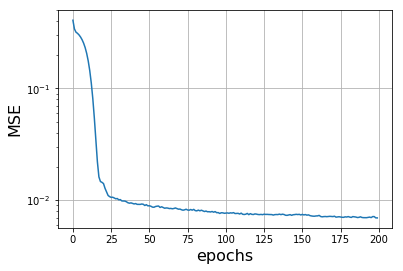

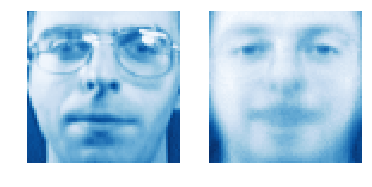

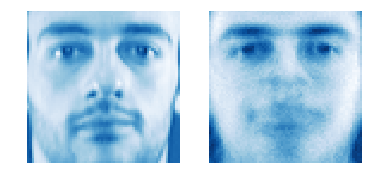

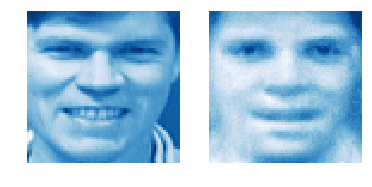

0.006946308

In [110]:
model = AE([4096, 200, 10], [10, 200, 4096])
fit_reconstruct(model, show_loss=True)

<i> 2.2 Какое качество восстановления удалось получить?</i>

не очень(

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

/Users/g.gospodinov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 0.0045245769433677255

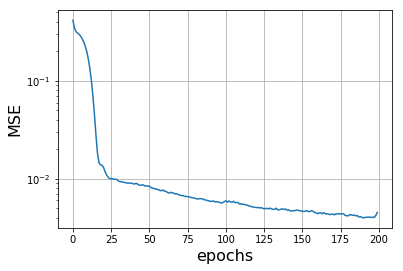

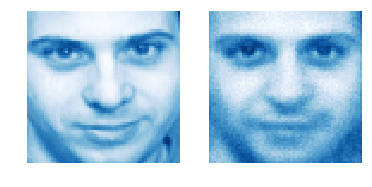

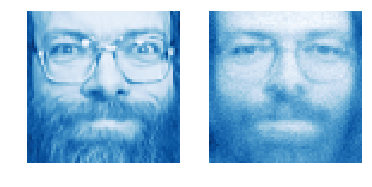

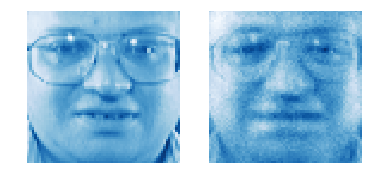

0.003975202

In [40]:
model = AE([4096, 200, 100], [100, 200, 4096])
fit_reconstruct(model, show_loss=True)

<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

/Users/g.gospodinov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


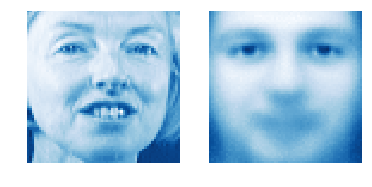

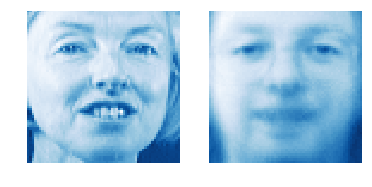

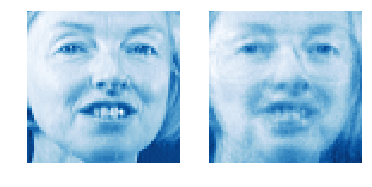

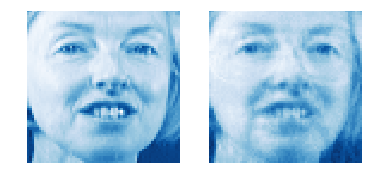

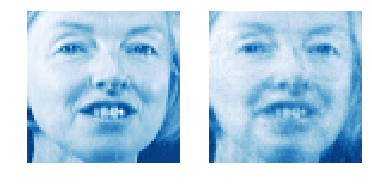

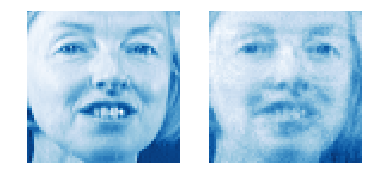

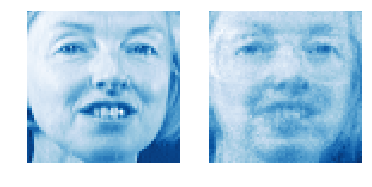

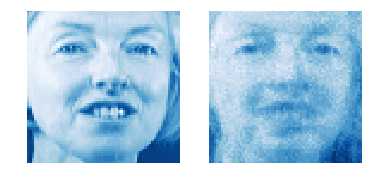

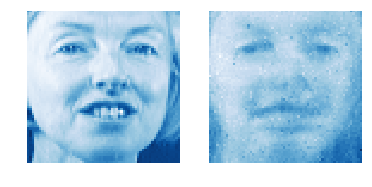

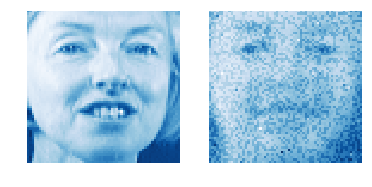

In [239]:
neurons_list = [1, 10, 100, 200, 400, 600, 800, 1000, 2000, 4096]
score = []
for neurons in neurons_list:
    model = AE([4096, neurons], [neurons, 4096])
    score.append(fit_reconstruct(model, distinct=True, show_convergence=False))

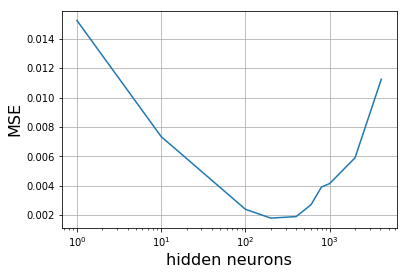

In [245]:
plt.plot(neurons_list, score)
plt.xscale('log')
plt.ylabel('MSE', fontsize=16)
plt.xlabel('hidden neurons', fontsize=16)
plt.grid()

Видно, что варьированием количества нейронов скрытого слоя можно добиться удовлетворительного восстановления (200-400 нейронов). С дальнейшим увеличением числа нейронов наблюдается расходимость. Я думаю, что это связано с одинаковой скоростью обучения для всех архитектур. То есть варьировать один параметр недостаточо)

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

/Users/g.gospodinov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 0.011416713707149029

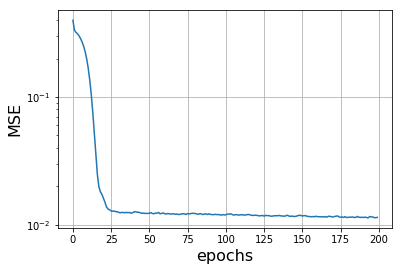

0.011310489

In [126]:
model = AE([4096, 200, 2], [2, 200, 4096])
fit(model, show_loss=True, show_convergence=True)

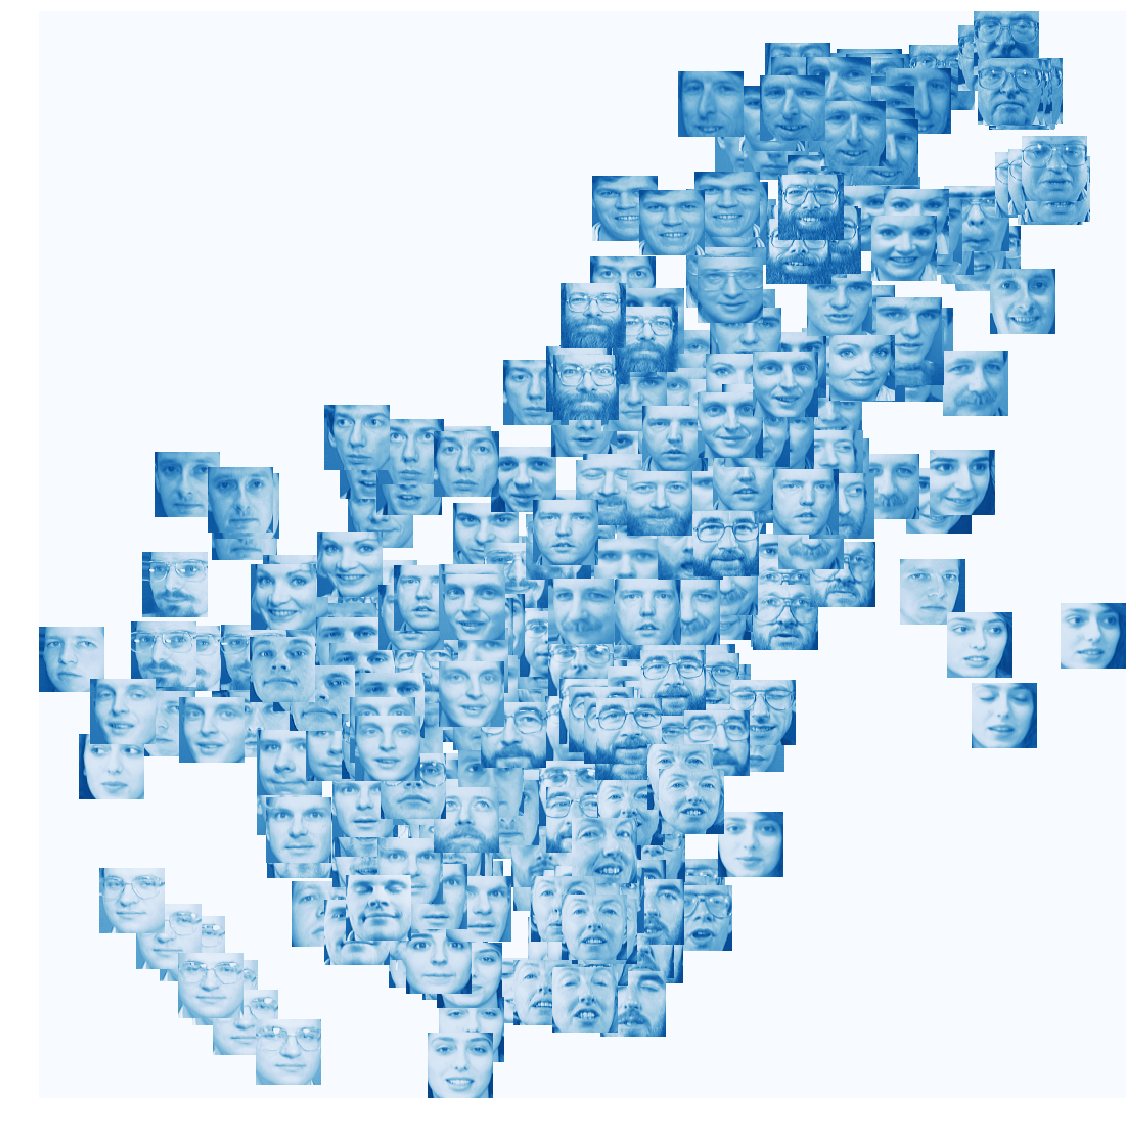

In [127]:
embs = model.encode(torch.Tensor(X)).data.numpy()
plot_dataset(X, embs)

Аналогично PCA видим, что изображения сильно разделились по интенсивности. В правом верхнем углу самые темные, в левом нижне - самые светлые. С глазами хуже, но ортоганальная прямая также видна: в правом нижнем и лево верхнем углах люди смотрят в противоположные стороны.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: